In [16]:
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')
mostafaabdlhamed_speech_signal_features_path = kagglehub.dataset_download('mostafaabdlhamed/speech-signal-features')

print('Data source import complete.')


Data source import complete.


In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile as sf

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [3]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [36.0 kB]
Get:13 http://archiv

# Importing Data

Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [4]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [13]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [6]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [7]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [8]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
surprise    192
disgust     192
fear        192
sad         192
happy       192
calm        192
angry       192
neutral      96


/tmp/ipython-input-3389392308.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [9]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [10]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

In [17]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


**Integration**

In [18]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [19]:
print(data_path.Emotions.value_counts())


Emotions
fear        1923
disgust     1923
happy       1923
sad         1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

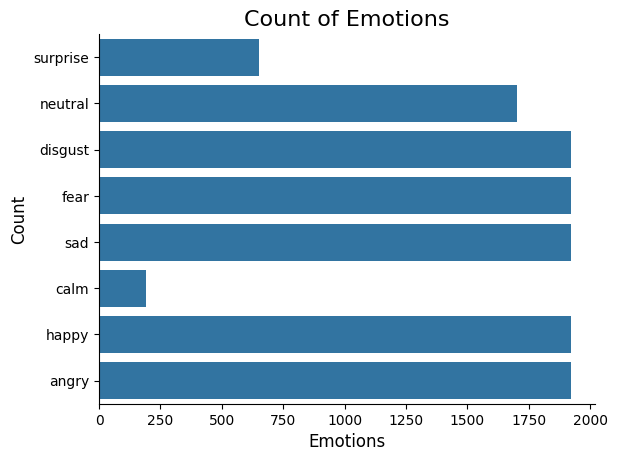

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [21]:
data,sr = librosa.load(file_path[0])
sr

22050

In [22]:
ipd.Audio(data,rate=sr)

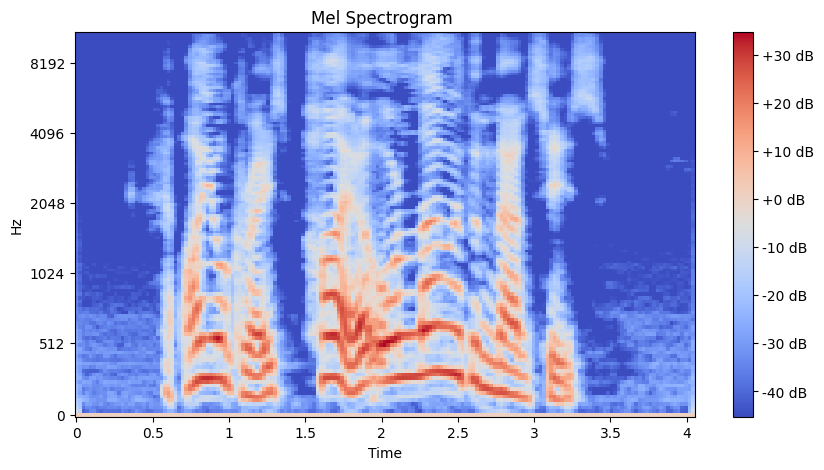

In [23]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

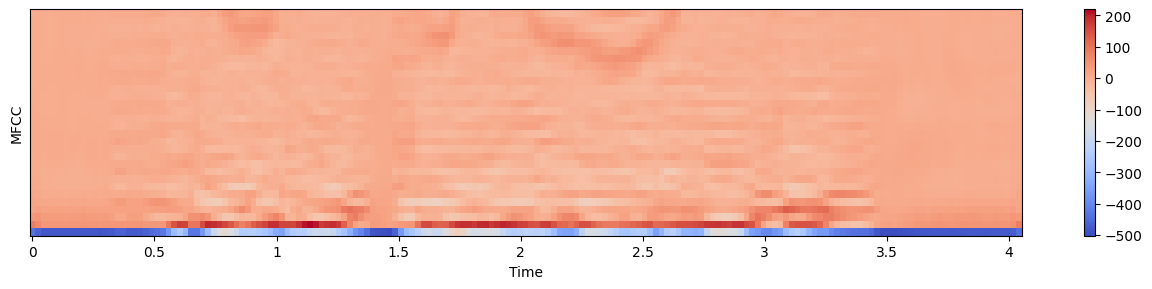

In [24]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [25]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y = data, rate = rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y= data, sr = sampling_rate, n_steps = pitch_factor)

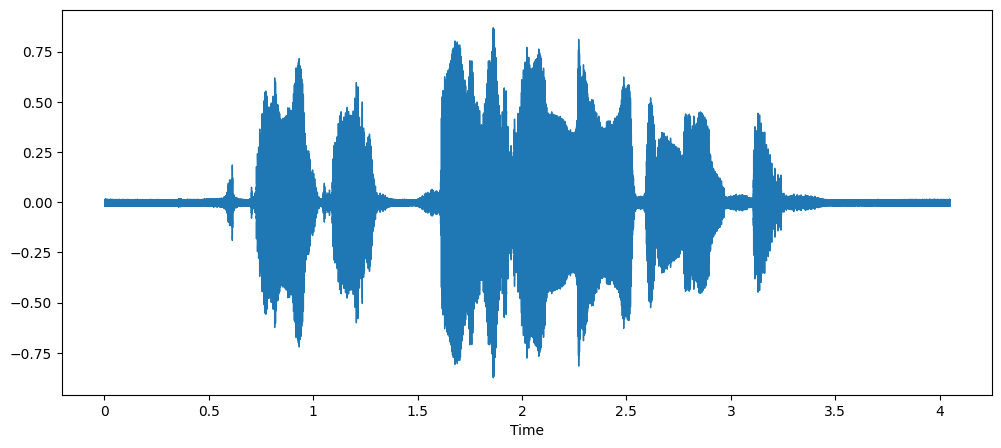

In [26]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

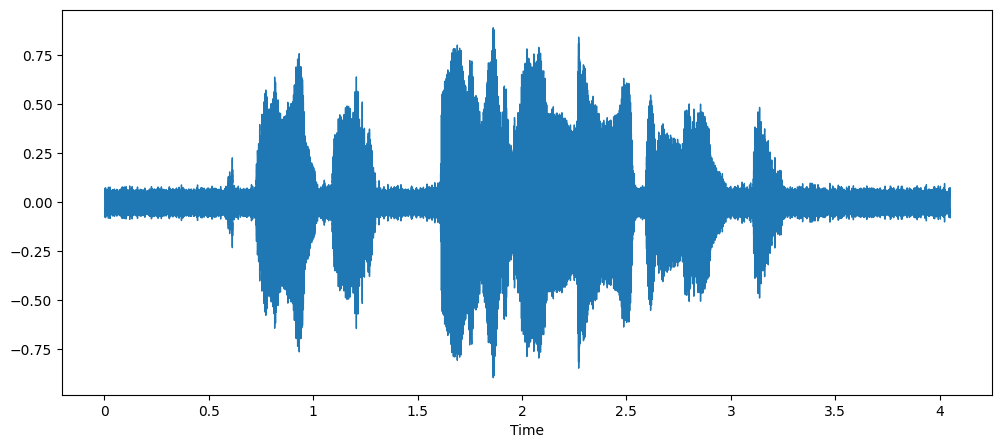

In [27]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

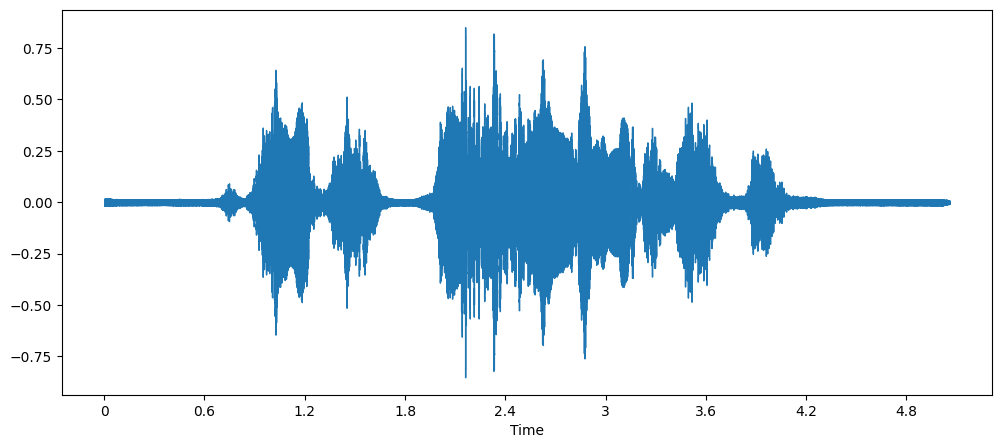

In [28]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

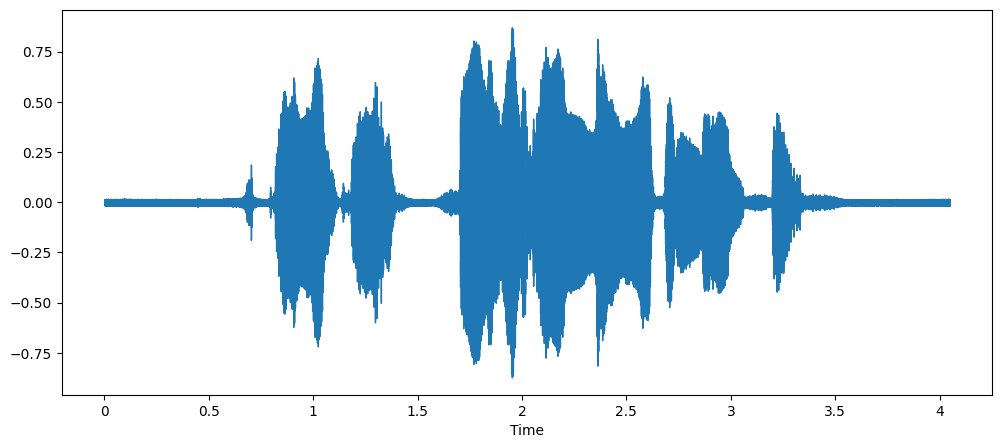

In [29]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

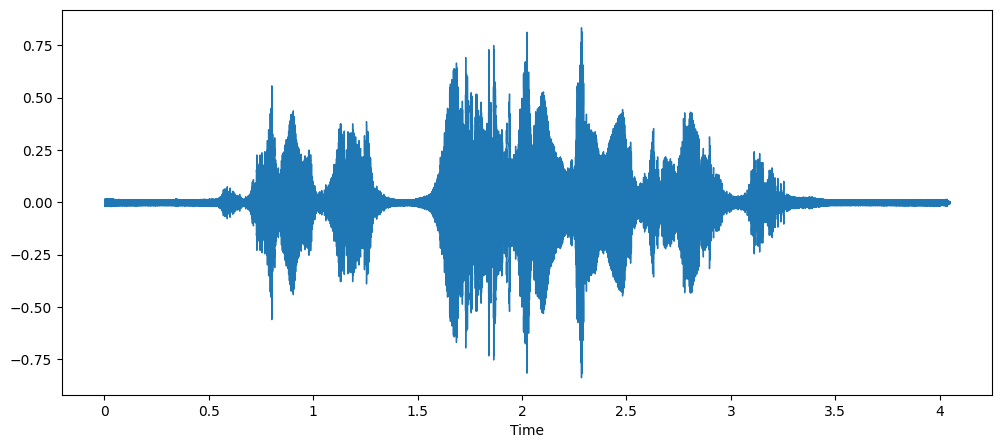

In [30]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [31]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y = data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y = data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y = data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [32]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [33]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  8.30it/s]

0 audio has been processed


502it [01:03,  8.80it/s]

500 audio has been processed


1002it [02:06,  8.66it/s]

1000 audio has been processed


1502it [03:07, 10.38it/s]

1500 audio has been processed


2003it [03:52, 12.49it/s]

2000 audio has been processed


2502it [04:38, 10.93it/s]

2500 audio has been processed


3002it [05:25, 11.24it/s]

3000 audio has been processed


3502it [06:12, 10.70it/s]

3500 audio has been processed


4003it [07:02,  9.86it/s]

4000 audio has been processed


4503it [07:49, 12.34it/s]

4500 audio has been processed


5003it [08:36, 11.45it/s]

5000 audio has been processed


5502it [09:25, 11.11it/s]

5500 audio has been processed


6001it [10:12, 10.51it/s]

6000 audio has been processed


6502it [11:01, 10.37it/s]

6500 audio has been processed


7003it [11:49, 11.13it/s]

7000 audio has been processed


7503it [12:37, 10.99it/s]

7500 audio has been processed


8003it [13:24, 10.28it/s]

8000 audio has been processed


8502it [14:12,  9.68it/s]

8500 audio has been processed


9003it [14:57, 14.61it/s]

9000 audio has been processed


9503it [15:32, 11.18it/s]

9500 audio has been processed


10003it [16:16, 12.16it/s]

10000 audio has been processed


10502it [17:03, 11.76it/s]

10500 audio has been processed


11002it [17:44, 12.52it/s]

11000 audio has been processed


11502it [18:26, 12.26it/s]

11500 audio has been processed


12001it [19:16,  8.18it/s]

12000 audio has been processed


12162it [19:35, 10.35it/s]

Done
Time:  1175.457432968


# Saving features

In [34]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.254883,0.382812,0.485840,0.436523,0.377441,0.315430,0.273926,0.260742,0.262207,0.260742,...,-5.509376,1.493500,-2.396860,0.479080,1.250789,-2.631915,0.853609,1.243965,2.391869,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518304,0.838670,1.308735,1.855114,2.405193,2.896440,3.283494,3.541683,3.667480,surprise
3,0.254883,0.379395,0.506836,0.499023,0.498535,0.500488,0.493652,0.493164,0.489258,0.487305,...,5.294544,2.649553,0.622543,1.345556,2.740193,-2.885994,-5.804974,-4.665290,-0.399955,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [35]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head(50)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.254883,0.382812,0.485840,0.436523,0.377441,0.315430,0.273926,0.260742,0.262207,0.260742,...,-5.509376,1.493500,-2.396860,0.479080,1.250789,-2.631915,0.853609,1.243965,2.391869,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518304,0.838670,1.308735,1.855114,2.405193,2.896440,3.283494,3.541683,3.667480,surprise
3,0.254883,0.379395,0.506836,0.499023,0.498535,0.500488,0.493652,0.493164,0.489258,0.487305,...,5.294544,2.649553,0.622543,1.345556,2.740193,-2.885994,-5.804974,-4.665290,-0.399955,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral
5,0.245117,0.373047,0.490723,0.495117,0.497559,0.495117,0.501953,0.501953,0.500000,0.498047,...,0.923949,1.641939,-0.407046,2.098418,-0.989813,-0.914428,0.356180,2.254576,0.518607,neutral
6,0.302246,0.432129,0.559082,0.503418,0.480957,0.447266,0.421875,0.404297,0.402832,0.416504,...,5.636771,5.757932,4.936170,3.190617,0.719465,-2.071464,-4.604100,-6.261052,-6.591945,neutral
7,0.256348,0.382324,0.502441,0.512695,0.497070,0.497559,0.497070,0.479004,0.487793,0.494141,...,2.805277,-0.228727,-2.449417,4.260848,1.696301,1.508067,-3.034211,-4.204701,-4.186650,neutral
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.063477,0.176758,0.176758,0.254883,0.365723,...,-1.825551,-24.133347,18.153677,-15.056425,-7.674027,-13.918596,-5.563495,-7.357308,-0.008657,disgust
9,0.252441,0.385254,0.512207,0.506836,0.506836,0.495117,0.495605,0.506348,0.504395,0.511230,...,-5.134304,-6.085646,-0.602992,-1.302998,-8.794124,-11.607110,-7.362681,2.058360,4.185491,disgust


In [36]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [37]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [38]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# Data preparation

In [39]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions

X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [40]:
import numpy as np
import pandas as pd

# Check if there are any NaN values in the data
if pd.DataFrame(X).isnull().values.any():
    print("Error: Data contains NaN values!")
    X = np.nan_to_num(X, nan=0.0)
else:
    print("No NaN values found in the data.")

# Check if there are any infinite values in the data
if not np.isfinite(X).all():
    print("Error: Data contains infinite (inf) values!")
else:
    print("No infinite values found in the data.")

No NaN values found in the data.
No infinite values found in the data.


In [41]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

Y_cleaned = np.array([str(val) for val in Y])
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y_cleaned.reshape(-1,1)).toarray()

print(f"shape after encoding: {Y.shape}")

shape after encoding: (48648, 8)


In [42]:
print(Y.shape)
X.shape

(48648, 8)


(48648, 2376)

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [44]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [45]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [46]:
import numpy as np

x_train_hash = [hash(tuple(row)) for row in x_train]
x_test_hash = [hash(tuple(row)) for row in x_test]
overlap = set(x_train_hash) & set(x_test_hash)
print("重复样本数（特征完全一致）:", len(overlap))


重复样本数（特征完全一致）: 2


In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


> Applying early stopping for all models


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [49]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='max',patience=10,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN model

In [50]:
#Reshape for CNN MODEL
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((38918, 2376, 1), (38918, 8), (9730, 2376, 1), (9730, 8))

In [51]:
from sklearn.utils import class_weight

# define weighted categorical crossentropy
y_integers = np.argmax(y_train, axis=1)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)
        return tf.reduce_mean(loss)
    return loss

In [52]:
import tensorflow.keras.layers as L
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight

model = tf.keras.Sequential([
    L.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
             kernel_regularizer=l2(1e-4),
             input_shape=(x_traincnn.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.4),

    L.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.3),


    L.Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.3),

    #L.Flatten(),
    L.GlobalAveragePooling1D(),


    L.Dense(32, activation='relu',
            kernel_regularizer=l2(1e-4)
            ),
    L.BatchNormalization(),
    L.Dropout(0.5),
    L.Dense(8, activation='softmax')
])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

model.compile(
    optimizer='adam',
    loss = weighted_categorical_crossentropy(class_weights_array),
    #loss='categorical_crossentropy',
    metrics=['accuracy']
    )
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1188, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 64)       │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 594, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 297, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,312 (196.53 KB)

 Trainable params: 49,800 (194.53 KB)

 Non-trainable params: 512 (2.00 KB)

In [53]:
def preprocess_data_improved(X, Y):

    # check and handle NaN values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    # standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # reshape the data for CNN input
    X_reshaped = np.expand_dims(X_scaled, axis=2)

    return X_reshaped, Y, scaler

In [54]:
#print("Unique labels in y_train_int:", np.unique(y_train_shape))
#print("Max label:", np.max(y_train_int))
#print("Min label:", np.min(y_train_int))
#print("Number of classes:", len(np.unique(y_train_int)))


In [55]:
# Check the shape of your labels
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Find the number of unique classes
# This should show 9 unique classes if your data is correct
y_integers = np.argmax(y_train, axis=1)
print("Unique classes found:", np.unique(y_integers))
print("Number of unique classes:", len(np.unique(y_integers)))

y_train shape: (38918, 8)
y_test shape: (9730, 8)
Unique classes found: [0 1 2 3 4 5 6 7]
Number of unique classes: 8


In [56]:
print("y_train.shape =", y_train.shape)
print("y_test.shape =", y_test.shape)
print("class_weights_array:", class_weights_array, "length:", len(class_weights_array))
print(model.output_shape)

y_train.shape = (38918, 8)
y_test.shape = (9730, 8)
class_weights_array: [0.78362597 8.10791667 0.79307956 0.78628576 0.80104561 0.89722427
 0.78286933 2.33882212] length: 8
(None, 8)


In [57]:
# Check the classes present in the test set
y_test_integers = np.argmax(y_test, axis=1)
print("Unique classes found in y_test:", np.unique(y_test_integers))

Unique classes found in y_test: [0 1 2 3 4 5 6 7]


In [ ]:
history=model.fit(
    x_traincnn,
    y_train,
    epochs=25,
    validation_data=(x_testcnn, y_test),
    #class_weight=class_weight,
    #batch_size=64,
    batch_size=32,
    callbacks=[early_stop,
               lr_reduction,
               model_checkpoint])

Epoch 1/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2204 - loss: 2.0037

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.2204 - loss: 2.0036 - val_accuracy: 0.3448 - val_loss: 1.4841 - learning_rate: 0.0010
Epoch 2/25
1212/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3367 - loss: 1.5316

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3368 - loss: 1.5315 - val_accuracy: 0.3617 - val_loss: 1.4731 - learning_rate: 0.0010
Epoch 3/25
1214/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3659 - loss: 1.4299

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3659 - loss: 1.4299 - val_accuracy: 0.3691 - val_loss: 1.4261 - learning_rate: 0.0010
Epoch 4/25
1212/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3900 - loss: 1.3913

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3901 - loss: 1.3912 - val_accuracy: 0.4293 - val_loss: 1.2694 - learning_rate: 0.0010
Epoch 5/25
1213/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4105 - loss: 1.3527

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4105 - loss: 1.3527 - val_accuracy: 0.4516 - val_loss: 1.2962 - learning_rate: 0.0010
Epoch 6/25
1212/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4180 - loss: 1.3334

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4181 - loss: 1.3333 - val_accuracy: 0.4695 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 7/25
1212/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4331 - loss: 1.2985

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4331 - loss: 1.2985 - val_accuracy: 0.4768 - val_loss: 1.1769 - learning_rate: 0.0010
Epoch 8/25
1214/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4440 - loss: 1.2708

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4440 - loss: 1.2708 - val_accuracy: 0.4800 - val_loss: 1.1770 - learning_rate: 0.0010
Epoch 9/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4545 - loss: 1.2589 - val_accuracy: 0.4624 - val_loss: 1.2351 - learning_rate: 0.0010
Epoch 10/25
1216/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4613 - loss: 1.2288

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4613 - loss: 1.2288 - val_accuracy: 0.4823 - val_loss: 1.1390 - learning_rate: 0.0010
Epoch 11/25
1212/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4673 - loss: 1.2195

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4673 - loss: 1.2195 - val_accuracy: 0.4921 - val_loss: 1.1391 - learning_rate: 0.0010
Epoch 12/25
1214/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4763 - loss: 1.2076

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4763 - loss: 1.2076 - val_accuracy: 0.5092 - val_loss: 1.1026 - learning_rate: 0.0010
Epoch 13/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4834 - loss: 1.1861 - val_accuracy: 0.5075 - val_loss: 1.0910 - learning_rate: 0.0010
Epoch 14/25
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4860 - loss: 1.1802 - val_accuracy: 0.5082 - val_loss: 1.0769 - learning_rate: 0.0010
Epoch 15/25
1214/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4836 - loss: 1.1883

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4836 - loss: 1.1883 - val_accuracy: 0.5249 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 16/25
 593/1217 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4951 - loss: 1.1559

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5612 - loss: 0.9489
Accuracy of our model on test data :  56.48509860038757 %


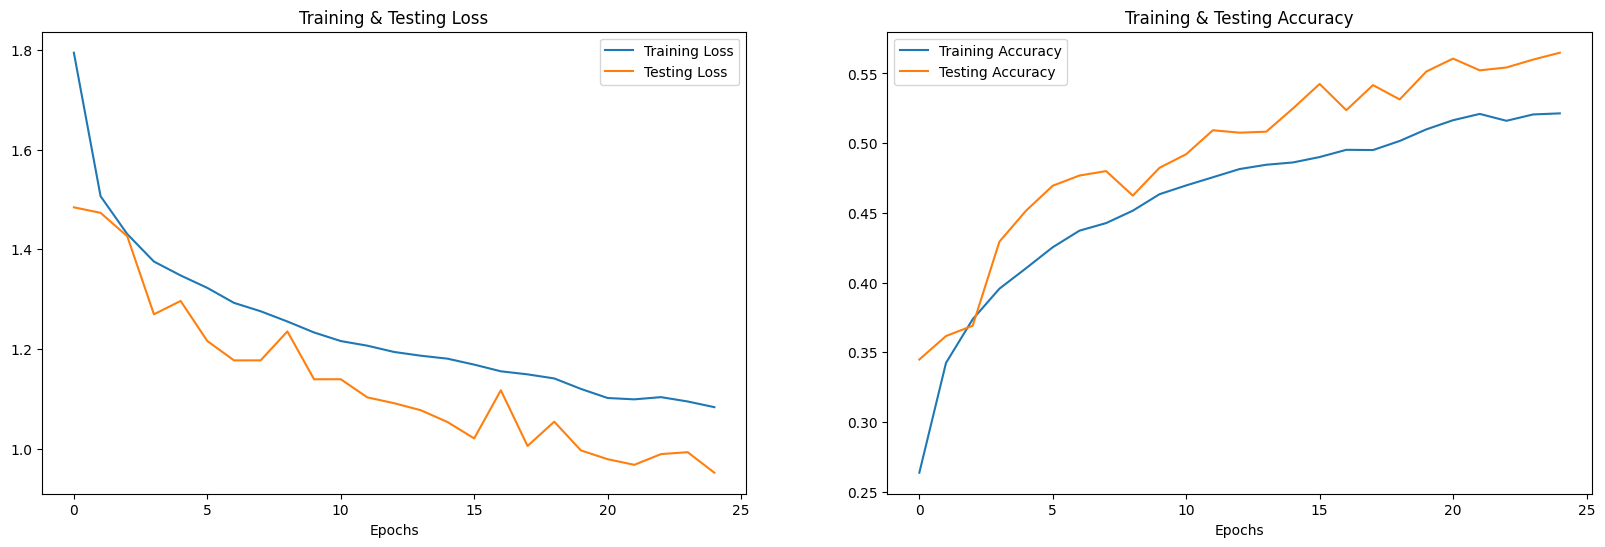

In [66]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

#epochs = [i for i in range(50)]

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

epochs = range(len(train_loss))

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
print(features.shape)
print(labels.shape)
labels = np.argmax(labels, axis=1)
df = pd.DataFrame(features)
df['label'] = labels
print(df.corr()['label'].sort_values())

In [63]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


,Predicted Labels,Actual Labels
0,surprise,angry
1,disgust,angry
2,sad,disgust
3,happy,happy
4,neutral,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [64]:
df0

,Predicted Labels,Actual Labels
0,surprise,angry
1,disgust,angry
2,sad,disgust
3,happy,happy
4,neutral,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,happy,neutral
9728,neutral,sad


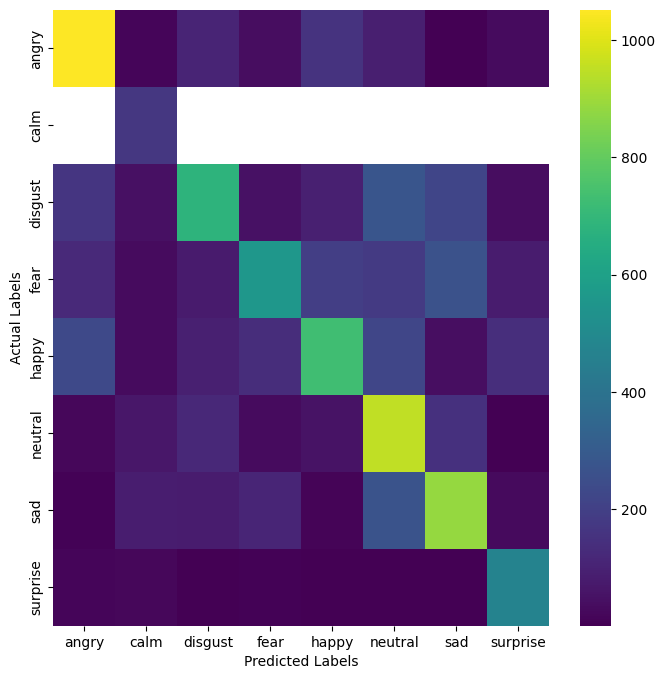

In [65]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Actual Labels'].value_counts()
    for x_label, grp in df0.groupby('Predicted Labels')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Predicted Labels')
_ = plt.ylabel('Actual Labels')

# Evalutation

Results of best model

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
# labels = list(encoder.categories_[0]) if isinstance(encoder.categories_[0], (list, np.ndarray)) else list(encoder.categories_)
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))

cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_map = {
    1: 'Neutral', 2: 'Calm', 3: 'Happy', 4: 'Sad',
    5: 'Angry', 6: 'Fear', 7: 'Disgust', 8: 'Surprise'
}
expected_labels = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

desired_numeric_order = [1, 2, 3, 4, 5, 6, 7, 8]

final_string_order = [label_map[i].lower() for i in desired_numeric_order]


cm = confusion_matrix(y_test0, y_pred0, labels=final_string_order)
cm_df = pd.DataFrame(cm, index=final_string_order, columns=final_string_order)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(y_test0, y_pred0, labels=final_string_order))

# Saving Best Model

In [ ]:
model.save_weights('SER_model.weights.h5')